In [43]:
from model import ASAG
import os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import features.functional as F

from sklearn.svm import SVC
from sklearn import metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
asag = ASAG()

In [5]:
asag.train_model()

Generating Features: 100%|██████████| 76/76 [26:49<00:00, 21.18s/it]


Tuned Threshold: 0.42
Accuracy:  0.8197831978319783
F1:  0.6956521739130435
Precision:  0.7004608294930875
Recall:  0.6909090909090909
Model Trained and Stored


In [6]:
asag.classifier_model.feature_importances_

array([0.05590925, 0.05935509, 0.07327595, 0.09064856, 0.03012222,
       0.0097719 , 0.06578545, 0.05439038, 0.05587381, 0.08229999,
       0.05852166, 0.11773256, 0.09941319, 0.04109756, 0.0488713 ,
       0.05693112])

In [10]:
# Get GIM Answers, Questions, Student Answers
df_response = pd.read_excel('Data/10X Capital Worksheet (Marked).xlsx').iloc[:,3:].iloc[:,np.arange(0,20,2)]
df_mark = pd.read_excel('Data/10X Capital Worksheet (Marked).xlsx').iloc[:,3:].iloc[:,np.arange(1,19,2)] # Only take for the first 9 questions
df_answers = pd.read_excel('Data/Answers.xlsx')
y_truth = pd.melt(df_mark).value.values
gim_student_answers = [df_response.transpose().iloc[i,:].to_list() for i in range(10)]
gim_reference_answers = df_answers.Answer.to_list()
gim_questions = [re.sub(r'\d+\) ','',q) for q in df_response.columns.to_list()]

In [12]:
y_pred = asag.grade(gim_student_answers[:-1], gim_reference_answers[:-1], gim_questions[:-1], y_truth = y_truth)

Generating Features: 100%|██████████| 9/9 [02:57<00:00, 19.76s/it]

Tuned Threshold: 0.21


In [45]:
threshold = F.tune_threshold(y_pred, y_truth, metrics.accuracy_score)

0.375

In [46]:
F.get_metrics((y_pred[:,1] > threshold).astype(np.long), y_truth)

Accuracy:  0.6135265700483091
F1:  0.6039603960396039
Precision:  0.6224489795918368
Recall:  0.5865384615384616


{'accuracy': 0.6135265700483091,
 'f1': 0.6039603960396039,
 'precision': 0.6224489795918368,
 'recall': 0.5865384615384616}

In [59]:
q = 6
print('Question')
print(gim_questions[q],'\n')

df = []
for idx, score in enumerate((y_pred[:,1])[22*q:22*(q+1)]):
    row = dict(
        computer_grade = 1 if score>0.375 else 0,
        human_grade = y_truth[22*q:22*(q+1)][idx],
        student_answer = gim_student_answers[q][idx]
    )
    df.append(row)

df = pd.DataFrame(df)
display(df[df.computer_grade != df.human_grade])

print('\nReference Answer')
print(gim_reference_answers[q])

Question
Why do low CAPEX companies have better growth prospects compared to high CAPEX companies? 



,computer_grade,human_grade,student_answer
1,1,0,Lesser capital is needed to maintain the exist...
3,1,0,It means that they required lower maintenance ...
6,1,0,"It is because in low CAPEX companies, whatever..."
10,0,1,Like airlines (hard to sustain during covid pe...
11,1,0,Because they will less likely to be cash - str...
16,1,0,I would say more FCF can be generated and with...
17,0,1,"Because they will have higher FCF, allowing it..."
18,0,1,The low capex requirement means that more earn...



Reference Answer
Because low CAPEX companies do not need to spend much on CAPEX, they have more Free Cash flow available for them to invest in future growth projects or plans.


3.815748743741325
3.8786952411875335
2.7324730403155453


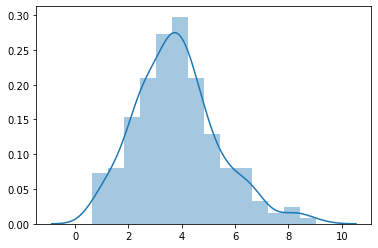

In [38]:
sns.distplot(y_pred[:,1]*10)
print(y_pred[:,1].mean()*10)
print(np.percentile(y_pred[:,1]*10,55))
print(np.percentile(y_pred[:,1]*10,25))